In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("../data/all_tickets_processed_improved_v3.csv")

df.head()

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [3]:
df.columns

Index(['Document', 'Topic_group'], dtype='str')

In [4]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df["cleaned_text"] = df["Document"].apply(clean_text)

df[["Document", "cleaned_text"]].head()

,Document,cleaned_text
0,connection with icon icon dear please setup ic...,connection icon icon dear please setup icon pe...
1,work experience user work experience user hi w...,work experience user work experience user hi w...
2,requesting for meeting requesting meeting hi p...,requesting meeting requesting meeting hi pleas...
3,reset passwords for external accounts re expir...,reset passwords external accounts expire days ...
4,mail verification warning hi has got attached ...,mail verification warning hi got attached plea...


In [5]:
vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(df["cleaned_text"])
y = df["Topic_group"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [8]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.8510660535117057

Classification Report:

                       precision    recall  f1-score   support

               Access       0.92      0.87      0.89      1455
Administrative rights       0.86      0.67      0.76       342
           HR Support       0.85      0.84      0.84      2107
             Hardware       0.80      0.89      0.84      2760
     Internal Project       0.93      0.80      0.86       451
        Miscellaneous       0.81      0.83      0.82      1400
             Purchase       0.97      0.87      0.92       497
              Storage       0.93      0.84      0.89       556

             accuracy                           0.85      9568
            macro avg       0.88      0.83      0.85      9568
         weighted avg       0.86      0.85      0.85      9568



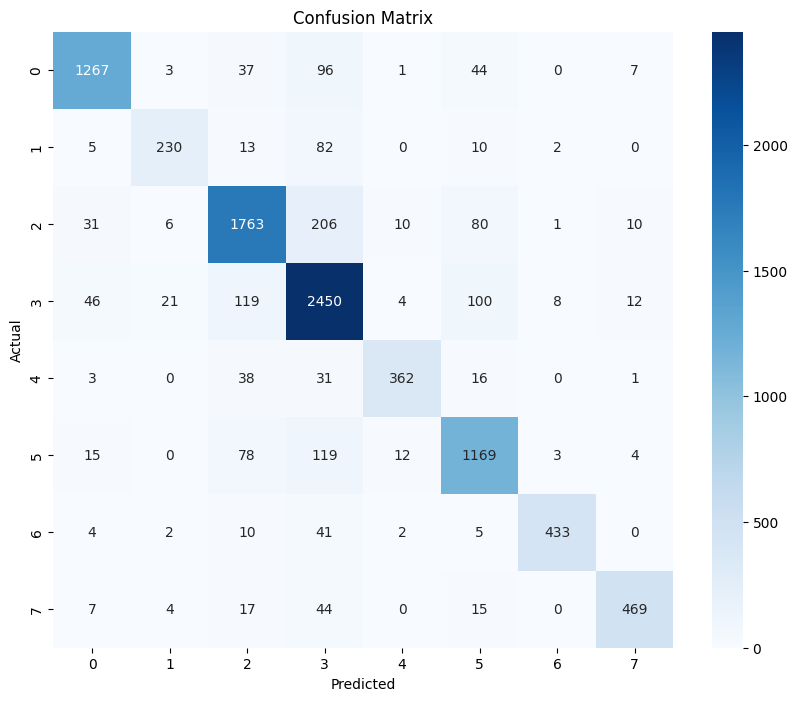

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
joblib.dump(model, "../src/ticket_model.pkl")
joblib.dump(vectorizer, "../src/vectorizer.pkl")

['../src/vectorizer.pkl']

In [11]:
def assign_priority(text):
    high_keywords = ['urgent', 'critical', 'down', 'failure', 'not working', 'error']
    medium_keywords = ['slow', 'issue', 'delay', 'problem']

    text = text.lower()

    if any(word in text for word in high_keywords):
        return "High"
    elif any(word in text for word in medium_keywords):
        return "Medium"
    else:
        return "Low"

df["Priority"] = df["Document"].apply(assign_priority)

df["Priority"].value_counts()

Priority
Low       33364
High       8065
Medium     6408
Name: count, dtype: int64

In [12]:
X_priority = vectorizer.transform(df["cleaned_text"])
y_priority = df["Priority"]

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_priority, y_priority, test_size=0.2, random_state=42
)

priority_model = LogisticRegression(max_iter=1000)
priority_model.fit(X_train_p, y_train_p)

y_pred_p = priority_model.predict(X_test_p)

print("Priority Accuracy:", accuracy_score(y_test_p, y_pred_p))
print(classification_report(y_test_p, y_pred_p))

Priority Accuracy: 0.9419941471571907
              precision    recall  f1-score   support

        High       0.96      0.81      0.88      1559
         Low       0.94      1.00      0.97      6713
      Medium       0.92      0.82      0.87      1296

    accuracy                           0.94      9568
   macro avg       0.94      0.87      0.90      9568
weighted avg       0.94      0.94      0.94      9568



In [13]:
joblib.dump(priority_model, "../src/priority_model.pkl")

['../src/priority_model.pkl']

In [14]:
df.columns

Index(['Document', 'Topic_group', 'cleaned_text', 'Priority'], dtype='str')